# Fine-tuning SAM on Satellite Images for Street Segmentation


---
### What to fine-tune:
- Only Mask Decoder
- Prompt Encoder & Mask Decoder

---
### Prompt Encoder: 
SAM has an prompt encoder part that takes either a list of point queries, a list of bounding boxes or masks as input. How can we use the prompt encoder in our pipeline?

#### Training

Use as input either: 
- No input
- List of point queries: 
    - Uniformly overlay the whole image with a grid of points
    - Sample coordinates of the street pixels as point queries
- Bounding box of whole image, part where streets are located, could split up streets into multiple bounding boxes
- Masks of the street pixels, could leak ground truth information? 

#### Evaluation/Testing 

- List of point queries: 
    - Uniformly overlay the whole image with a grid of points
- No input
- Bounding box of whole image

---
### Loss function: 
- F1-Loss: https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.multiclass_f1_score.html
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing

--- 
## Things we could try later:  

Since the model is promptable, try to chain the model using the mask input. Maybe use a similar approach as in diffusion models


In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import sam_dataset

device = get_torch_device(allow_mps=True)
print(device)

###########


original_data = {}
original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()

city_names = ["boston","nyc","zurich"]

custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

assert (len(custom_data["images"]) == len(custom_data["masks"]))

/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. S

mps


In [3]:
print(np.unique(original_data["masks"][0]))
print(np.unique(custom_data["masks"][0]))

[  0 255]
[  0 255]


In [4]:
print(len(custom_data["images"]))

print(get_street_ratio_mmm(custom_data["masks"]))
print(get_street_ratio_mmm(original_data["masks"]))


9208
(0.0, 0.1329543182558652, 0.72180625)
(0.008968750000000001, 0.17797695312500006, 0.40426875)


In [6]:

# create a dataset
custom_data_set = sam_dataset(custom_data["images"], custom_data["masks"])
original_data_set = sam_dataset(original_data["images"],original_data["masks"])
print(len(custom_data_set[0]))

2


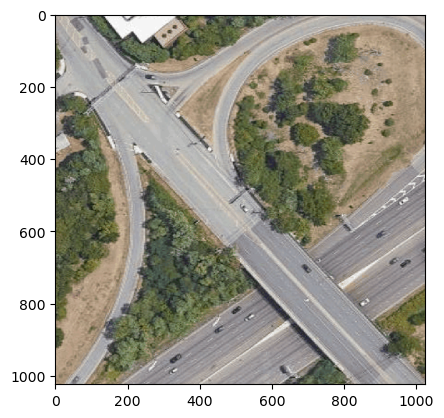

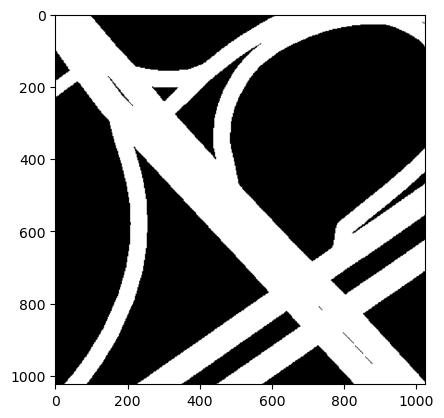

In [14]:
sample = custom_data_set[0]
plt.imshow(sample[0].swapaxes(0,2))
plt.show()
plt.imshow(sample[1].swapaxes(0,2))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


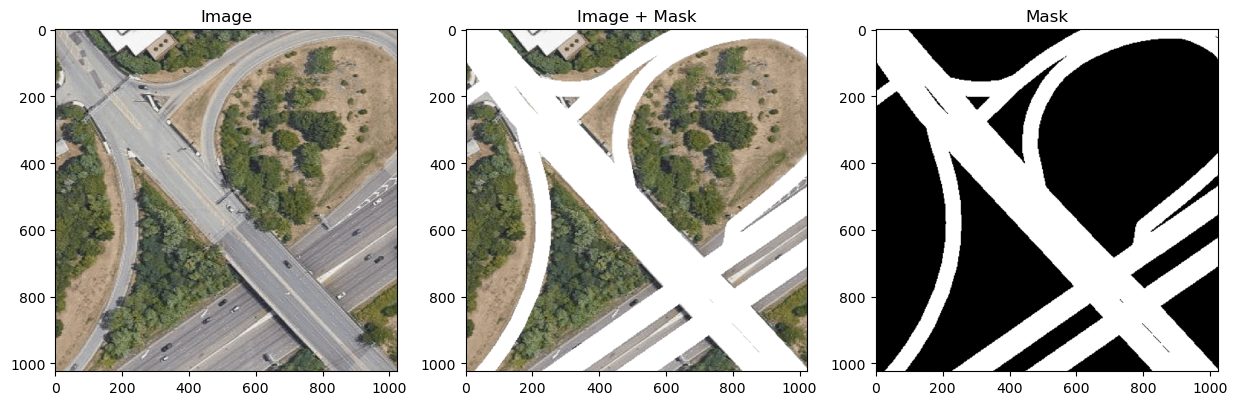

0.003921569 0.99607843 0.0 1.0


In [15]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 0
image, mask = custom_data_set[idx]

img = np.array(image)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)

# image + mask overlay
plt.subplot(1, 3, 2)
plt.title("Image + Mask")
plt.imshow(img + mask)

# mask
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()


print(img.min(), img.max(), mask.min(), mask.max())


## Dataloader

In [18]:
train_split = 0.8
batch_size = 10


import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

train_dataloader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, drop_last=False,num_workers=0)
test_dataloader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=True, drop_last=False,num_workers=0)

7367 1841


In [19]:
for image,mask in train_dataloader:
    print(image.shape, mask.shape)
    break

torch.Size([100, 3, 1024, 1024]) torch.Size([100, 3, 1024, 1024])


## Loading the model

In [20]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *


model_path = "custom_segment_anything/model_checkpoints/sam_vit_h_4b8939.pth"
sam = sam_model_registry["default"](checkpoint=model_path)
sam.to(device)
conv_decoder = Conv_Decoder()

model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=conv_decoder,encoder_finetune_num_last_layers=6)
model = model.to(device)

print(model)


Last layer number: 456
EncoderSAM_CustomDecoder(
  (sam_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

## Training Loop

TODO:::

Note that right now the model is not using a sigmoid function in the last layer. 

implement the right loss function and test out different versions, add saving of the model version after training 

add evaluation of test dataloader to see prediction result. 

In [ ]:
# load the model state

name = "model_epoch3.pth"

model.load_state_dict(torch.load(name))


In [ ]:

print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

In [ ]:
import torch
import tqdm
from torcheval.metrics.functional import multiclass_f1_score

bce_loss = torch.nn.BCEWithLogitsLoss(reduction="sum")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 15


for epoch in range(3,num_epochs):
    running_loss = 0.0
    i = 0
    for image, mask in train_dataloader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        # first steps of the model with no gradients
        
        x =model.sam_preprocess(image)
        x = model.sam_encoder(x)
        pred = model.decoder(x)
        
        #pred = model(image)

        # pred has shape (batch_size, 1, 1024, 1024)
        pred = pred[:,0,:,:] # [batch_size, 1024, 1024]
        # mask has shape (batch_size, 3, 1024, 1024)
        mask = mask[:,0,:,:] # [batch_size, 1024, 1024]

        # stretch the pred to one dimension
        loss = bce_loss(pred, mask)

        #loss = multiclass_f1_score(pred, mask,num_classes=2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(loss.item(),"step:",i,"of",len(train_dataloader))
        i += 1
    print(f"Epoch: {epoch}, Loss: {running_loss/len(train_dataset)}")

    if epoch % 2 == 0:
        # save the model
        torch.save(model.state_dict(), f"model_epoch{epoch}.pth")

# save the model
torch.save(model.state_dict(), "model_tr1.pth")
